## Import Libraries

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn import metrics, linear_model
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, precision_recall_curve, make_scorer, f1_score, classification_report
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import det_curve, DetCurveDisplay
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import warnings

In [2]:
# Number of anomalies in the data set / Total number of data points. Will be used to estimte the SCORE_THREHOLD.
ANOMALY_RATIO = 0.01

# Data points below this therhold will be consider an anomaly
SCORE_THREHOLD = 0.01

# Rows of data to skip. Skip rows to reduce data set size
SKIP_ROWS = 17157691

## Load data from file

In [3]:
#Surpass Warnings
warnings.filterwarnings('ignore')

# Load file from Google drive
from google.colab import drive
drive.mount('/content/drive')

now = datetime.now()
print('File Load Start Time:', now)

# Define header columns. Original header columns will be gone if rows are skipped when loading the file
column_names=["IpId","UserId",'TimeStamp','HttpMethod','Uri','HttpVersion','ResponseCode','Bytes','Referrer','UserAgent']

# Load data from file
df = pd.read_csv('/content/drive/MyDrive/3253-Machine-Learning/Project/eclog.csv', skiprows=SKIP_ROWS, names=column_names)

now = datetime.now()
print('File Load End Time:', now)

# Drop the unused columns
if 'Unnamed: 0' in df:
  df.drop('Unnamed: 0', axis=1, inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File Load Start Time: 2022-12-01 15:08:38.958956
File Load End Time: 2022-12-01 15:10:51.258246


## Extract Features

In [4]:
# Process and parse the timestamps
df['TimeStamp2'] = (df['TimeStamp']/(10e6) - 62135769600).apply(datetime.fromtimestamp)

# Group the logs by hours and get the unique number of values for each column
df_temp = df.groupby(pd.Grouper(key="TimeStamp2", freq="30min")).nunique()

# Count the total number of logs within each hour.
df_temp["count"] = df.groupby(pd.Grouper(key="TimeStamp2", freq="30min")).count()["TimeStamp"]

# Rename the columns
df_temp = df_temp.reset_index() 
df_temp = df_temp.rename(columns={'count': 'value'})
df_temp = df_temp.rename(columns={'TimeStamp': 'uTimeStamp'})
df_temp = df_temp.rename(columns={'IpId': 'uIps'})
df_temp = df_temp.rename(columns={'UserId': 'uUserIds'})
df_temp = df_temp.rename(columns={'HttpMethod': 'uHttpMethods'})
df_temp = df_temp.rename(columns={'Uri': 'uUris'})
df_temp = df_temp.rename(columns={'HttpVersion': 'uHttpVersions'})
df_temp = df_temp.rename(columns={'ResponseCode': 'uResponseCodes'})
df_temp = df_temp.rename(columns={'Bytes': 'uBytes'})
df_temp = df_temp.rename(columns={'Referrer': 'uReferrers'})
df_temp = df_temp.rename(columns={'UserAgent': 'uUserAgents'})
df_temp = df_temp.rename(columns={'TimeStamp2': 'timestamp'})
df=df_temp
df.head()

,timestamp,uIps,uUserIds,uTimeStamp,uHttpMethods,uUris,uHttpVersions,uResponseCodes,uBytes,uReferrers,uUserAgents,value
0,2020-02-24 12:30:00,84,1,431,2,1210,1,7,1249,89,43,2425
1,2020-02-24 13:00:00,155,1,1280,2,3079,1,7,2962,192,78,6834
2,2020-02-24 13:30:00,144,1,1380,3,3967,1,7,3607,224,80,10730
3,2020-02-24 14:00:00,141,1,1261,2,3237,1,7,3050,152,72,6933
4,2020-02-24 14:30:00,136,1,1264,3,2826,1,7,2647,131,66,6290


## Explore Data

## Extract Features

In [5]:
# Extract features from timestamp

df["hour"]=df.timestamp.dt.hour

df["minute"]=df.timestamp.dt.minute

df["weekday"]=pd.Categorical(df.timestamp.dt.strftime('%A'), categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

df['day']=df.timestamp.dt.weekday

# Combine hour and minute
df["hour_minute"]=df.timestamp.dt.hour*100 + df.timestamp.dt.minute

# Add Lag features
df["value_lag1D"] = df['value'].shift(48) # 1 day = 48 * 30 min
df["value_lag1D"] = df["value_lag1D"].fillna(0)
df["value_lag2D"] = df['value'].shift(96) # 2 day = 96 * 30 min
df["value_lag2D"] = df["value_lag2D"].fillna(0)
df["value_lag7D"] = df['value'].shift(336) # 2 day = 336 * 30 min
df["value_lag7D"] = df["value_lag7D"].fillna(0)

# Add rolling window features
df["value_rolling_mean"] = df['value'].rolling(window=2).mean()
df["value_rolling_mean"] = df["value_rolling_mean"].fillna(0)

df["value_rolling_min"] = df['value'].rolling(window=2).min()
df["value_rolling_min"] = df["value_rolling_min"].fillna(0)

df["value_rolling_max"] = df['value'].rolling(window=2).max()
df["value_rolling_max"] = df["value_rolling_max"].fillna(0)



In [6]:
# Set the target.
# Skipped because data set is not labeled
#df['is_anomaly'] = df['is_anomaly'].astype(int)
#df['is_anomaly'] = df['is_anomaly'].replace(1, -1).replace(2, -1).replace(0,1)
df['is_anomaly']=0

## Explore the data

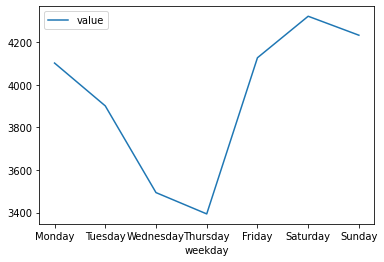

In [7]:
# How the number of events vary with different days of the week.
df[["value", "weekday"]].groupby('weekday').mean().plot()

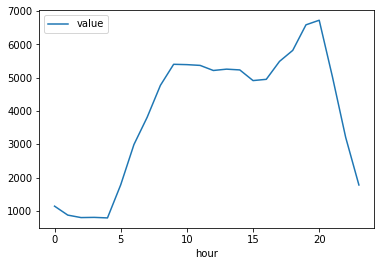

In [8]:
# How the number of events vary with different hours of the day
df[["value", "hour"]].groupby('hour').mean().plot()

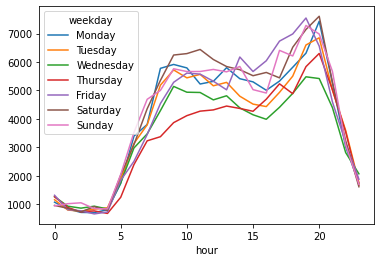

In [9]:
df.groupby(['hour','weekday']).mean()['value'].unstack().plot()

In [10]:
df.groupby(['hour','weekday'])['value'].mean()

hour  weekday  
0     Monday       1072.538462
      Tuesday      1158.214286
      Wednesday    1266.392857
      Thursday     1263.250000
      Friday       1316.964286
                      ...     
23    Wednesday    2070.857143
      Thursday     1675.107143
      Friday       1880.807692
      Saturday     1615.846154
      Sunday       1706.423077
Name: value, Length: 168, dtype: float64

In [11]:
df_final = df.join(df.groupby(['minute', 'hour','weekday'])['value'].mean(),on=['minute', 'hour','weekday'],rsuffix='_avg')

In [12]:
# Estimate the anomaly ratio. 
# Will not estimate because data is unlabeled.

# Use the default anomaly ratio 0.1
print("ANOMALY_RATIO:", ANOMALY_RATIO)

ANOMALY_RATIO: 0.01


In [13]:
X = df_final[['value',
              #'value_avg',   # Remove the following features because they led to wrose performance
              #'value_lag1D',
              #'value_lag2D',
              #'value_lag7D',
              'value_rolling_mean',
              'value_rolling_min',
              'value_rolling_max',
              'minute',
              'hour',
              'hour_minute',
              'day']]

y = df_final['is_anomaly']

# Remove the first 336 data point because they lack rolling and lagging values
X=X[336:]
y=y[336:]
df_final=df_final[336:]
X=X.reset_index().drop(['index'], axis=1)
y=y.reset_index().drop(['index'], axis=1)
df_final=df_final.reset_index().drop(['index'], axis=1)

In [14]:
print(len(X))
print(len(y))

4243
4243


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
# Scale the features
stdScaler = StandardScaler()
X_train_scaled = stdScaler.fit_transform(X_train)
X_test_scaled = stdScaler.transform(X_test)
X_scaled = stdScaler.transform(X)

In [17]:
model = IsolationForest(contamination=0.01, random_state=42)
param_grid = {'n_estimators': [500], 'max_samples': [0.9], 'max_features': [len(X.columns), len(X.columns)-1], 'bootstrap': [False], 'n_jobs': [5]}

grid_search = GridSearchCV(model, 
                          param_grid,
                          scoring='roc_auc',
                          refit=True,
                          cv=10, 
                          return_train_score=True)

now = datetime.now()
print('GridSearchCV Start Time:', now)

best_model = grid_search.fit(X_train_scaled)

now = datetime.now()
print('GridSearchCV End Time:', now)

print('Optimum parameters', best_model.best_params_)

GridSearchCV Start Time: 2022-12-01 15:12:12.167257
GridSearchCV End Time: 2022-12-01 15:13:03.790696
Optimum parameters {'bootstrap': False, 'max_features': 8, 'max_samples': 0.9, 'n_estimators': 500, 'n_jobs': 5}


In [18]:
# Predict the anomalies
y_predict_test = best_model.predict(X_test_scaled)
y_predict_all = best_model.predict(X_scaled)

# Calculate the anomaly scores
y_scores_test = best_model.decision_function(X_test_scaled)
y_scores_all = best_model.decision_function(X_scaled)

## Model evaluation

SCORE_THREHOLD: -0.0016782148828516444


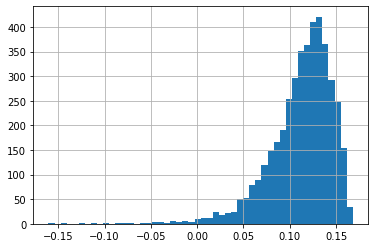

In [19]:
# Add score column
df_final['score']=y_scores_all
df_final['predict']=y_predict_all

# Estimate the score threhold. Data points lower than this are anomalies
ANOMALY_RATIO_FACTOR = 1 # for adjusting the therhold
SCORE_THREHOLD = df_final['score'].quantile(ANOMALY_RATIO * ANOMALY_RATIO_FACTOR)
print("SCORE_THREHOLD:", SCORE_THREHOLD)
df_final['score'].hist(bins=50)

# Add outlier column
df_final['score_outliers']   = pd.Series(y_scores_all).apply(lambda a:1 if(a < SCORE_THREHOLD) else 0)
df_final['predict_outliers'] = pd.Series(y_predict_all).apply(lambda a:1 if(a < 0) else 0)

# Get all types of anomalies. 
# 1. True anomalies
true_anomaly = df_final[df_final["is_anomaly"]==-1]

# 2. Predicted anomalies
predicted_anomaly_index = np.where(y_predict_all < 0)
predicted_anomaly = df_final[df_final.index.isin(predicted_anomaly_index[0])]

# 3. Score based anomalies
score_based_anomaly_index = np.where(y_scores_all < SCORE_THREHOLD)
score_based_anomaly = df_final[df_final.index.isin(score_based_anomaly_index[0])]

In [20]:
def plot(plt, title):
  plt.figure(figsize=(19,5))
  plt.ylabel('Totoal number of requests')
  plt.xlabel('Time')
  plt.ylim(ymin=y_min, ymax=y_max)
  plt.xlim(xmin=start_date, xmax=end_date)
  plt.plot(df_final['timestamp'], df_final['value'], label='Number of requests')
  plt.plot(df_final['timestamp'], df_final['score']*SCALE, linestyle=(0, (1, 1)), color='b', label='Anomaly score give by decision function')
  plt.plot(true_anomaly['timestamp'], true_anomaly['value'], "bo", label="Labeled anomalies")
  plt.plot(score_based_anomaly['timestamp'], score_based_anomaly['value'], "rx", label="Predicted anomalies")
  plt.axhline(y=SCORE_THREHOLD*SCALE, color='b', linestyle='-')
  plt.eventplot(score_based_anomaly['timestamp'],lineoffsets=10000,linelengths=200000,color='r', alpha=0.1)
  plt.title(title)
  plt.legend()


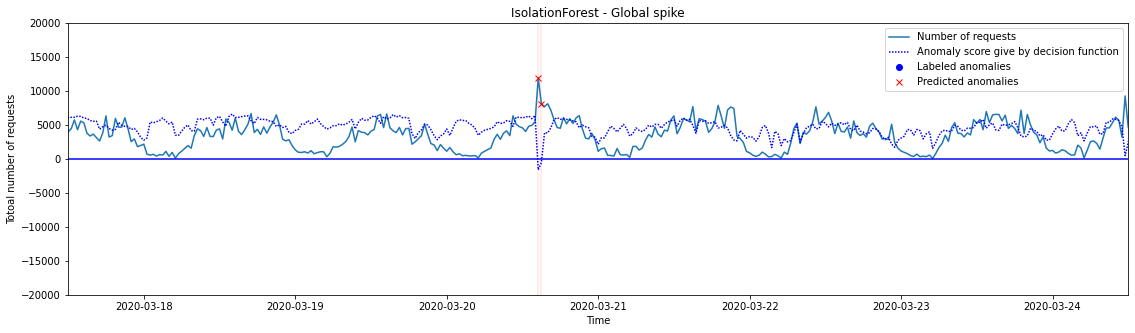

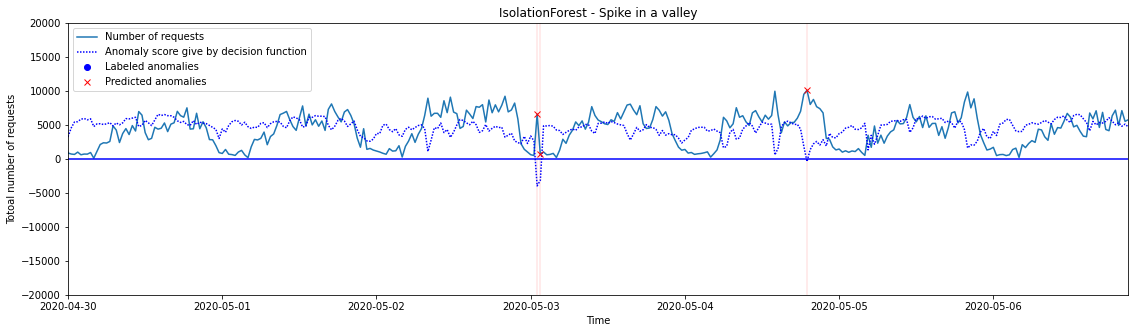

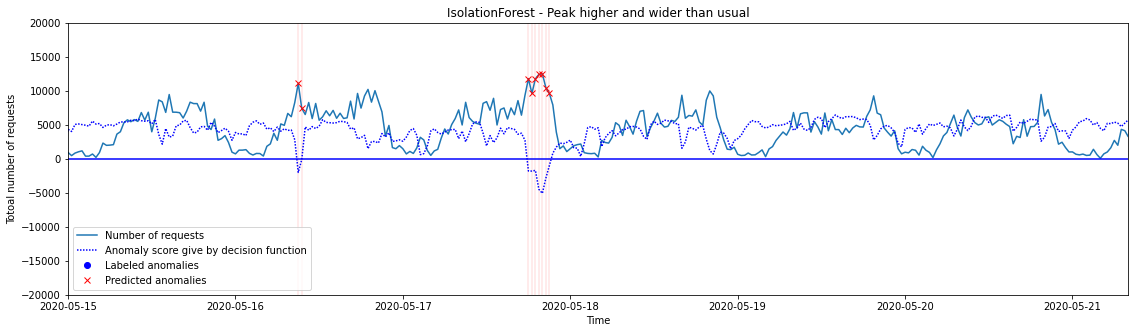

In [21]:
y_max=20000
y_min=-20000
SCALE=40000

# Selected detected anomalies here

# Single spike -Global
start_date = datetime.strptime("2020-03-17 12", '%Y-%m-%d %H')
end_date = datetime.strptime("2020-03-24 12", '%Y-%m-%d %H')
plot(plt, "IsolationForest - Global spike")

# Spike at valley -In a valley
start_date = datetime.strptime("2020-04-30 0", '%Y-%m-%d %H')
end_date = datetime.strptime("2020-05-6 21", '%Y-%m-%d %H')
plot(plt, "IsolationForest - Spike in a valley")

# Peak higher than usual
start_date = datetime.strptime("2020-05-15 0", '%Y-%m-%d %H')
end_date = datetime.strptime("2020-05-21 8", '%Y-%m-%d %H')
plot(plt, "IsolationForest - Peak higher and wider than usual")


In [22]:
fig = px.histogram(df_final,x='score',color='score_outliers')
fig.show()

In [23]:
fig = px.scatter(df_final.reset_index(), x='timestamp', y='value', color="score_outliers",title="NYC Taxi Demand")
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [24]:
fig = px.scatter(df_final.reset_index(), x='timestamp', y='value', color="predict_outliers",title="NYC Taxi Demand")
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()